In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import qiskit
from qiskit import QuantumCircuit, Aer, transpile, IBMQ, execute, schedule
from qiskit.test.mock.backends.toronto.fake_toronto import FakeToronto
from qiskit.test.mock.backends.rome.fake_rome import FakeRome

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-sherbrooke')

In [3]:
qasm_sim = provider.get_backend('ibmq_qasm_simulator')
sydney = provider.get_backend('ibmq_sydney')

In [4]:
syd_conf = sydney.configuration()
syd_prop = sydney.properties()

In [127]:
# Find highest single-qubit gate error rate
highest_e = 0
qubit_e = None
lowest_t1 = 1
qubit_t1 = None

for q in range(syd_conf.num_qubits):
    current_e = syd_prop.gate_error('sx', q)
    current_t1 = syd_prop.t1(q)
    if highest_e < current_e:
        qubit_e = q
        highest_e = current_e
    if lowest_t1 > current_t1:
        qubit_t1 = q
        lowest_t1 = current_t1
print(f'Highest single-qubit gate error rate: qubit {qubit_e}')
print(f'Lowest T1: qubit {qubit_t1}')


Highest single-qubit gate error rate: qubit 12
Lowest T1: qubit 0


In [141]:
print('\n'.join([f'T1 for highest single-qubit error: {syd_prop.t1(qubit_e)}', f'Lowest T1: {syd_prop.t1(qubit_t1)}']))

T1 for highest single-qubit error: 7.242632326807035e-05
Lowest T1: 4.1094777326472683e-05


## One quibit circuit

In [135]:
def x_measure():
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.measure_all()
    qc.h(0)
    return qc
xmeas = x_measure()
xmeas_native_e = transpile(xmeas, sydney, initial_layout=[qubit_e])
xmeas_native_t1 = transpile(xmeas, sydney, initial_layout=[qubit_t1])
xmeas_sched = schedule(xmeas_native, sydney)
print(f'Duration of the mid-circuit X-measurement: {xmeas_sched.duration}[dt]')

Duration of the mid-circuit X-measurement: 24400[dt]


In [119]:
# What is dt for Sydney?
print('\n'.join([f'Qubit drive channel: {syd_conf.dt}s', f'Qubit measurement drive channel: {syd_conf.dtm}s']))

Qubit drive channel: 2.2222222222222221e-10s
Qubit measurement drive channel: 2.2222222222222221e-10s


In [136]:
slots = 10

def get_circuit_list(q, xmeas):
    circuits = []

    for i in range(slots):
        qc = QuantumCircuit(1,1)
        qc.h(0)
        qc = transpile(qc, sydney, initial_layout=[q])
        
        for _ in range(i):
            qc = qc.compose(xmeas)
        qc.delay((slots-i-1) * xmeas_sched.duration, qarg=q)
        qc.measure(q, 0)
        circuits.append(qc)
    return circuits

In [39]:
# Run the same circuits 30 times in order to have statistical average
job = execute(get_circuit_list(qubit_e, xmeas_native_e)*30, qasm_sim, backend_properties=syd_prop, optimization_level=0, shots=4096) #, initial_layout=[qubit]
job.job_id()

'605b7a6811fac48b97943b63'

In [113]:
res = provider.backends.retrieve_job('605b7a6811fac48b97943b63').result()

sim_ratio = [c['1']/c['0'] for c in res.get_counts()]
sim_df = pd.DataFrame(columns=['number_meas', 'ratio'])
for i in range(len(sim_ratio)):
    entry = {'number_meas': i%10, 'ratio': sim_ratio[i]}
    sim_df = sim_df.append(entry, ignore_index=True)
sim_df = sim_df.astype({'number_meas': int})

In [19]:
job = execute(get_circuit_list(qubit_e, xmeas_native_e), sydney, shots=4096, optimization_level=0)
job.job_id()

'605b5dd46b0b890f14adb373'

In [131]:
res_e = provider.backends.retrieve_job('605b5dd46b0b890f14adb373').result()

syd_ratio_e = [c['1']/c['0'] for c in res_e.get_counts()]

In [138]:
job = execute(get_circuit_list(qubit_t1, xmeas_native_t1), sydney, shots=4096, optimization_level=0)
job.job_id()

'605b9edf2b8d410b72652de2'

In [139]:
res_t1 = provider.backends.retrieve_job('605b9edf2b8d410b72652de2').result()

syd_ratio_t1 = [c['1']/c['0'] for c in res_t1.get_counts()]

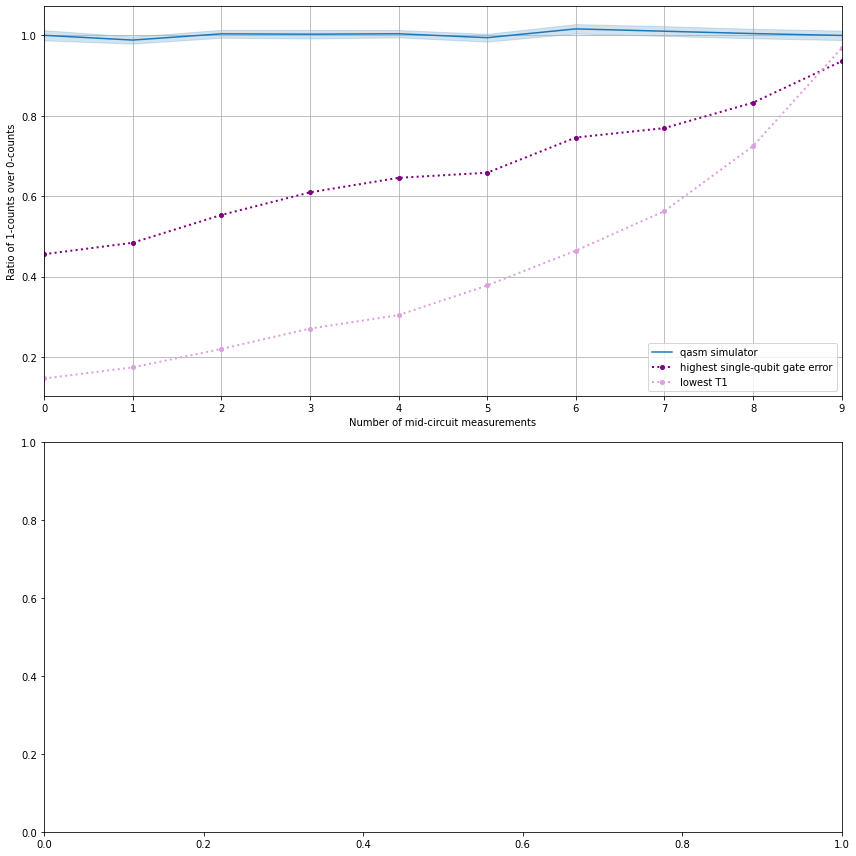

In [140]:
fig, axs = plt.subplots(2, figsize=(12,12))

sns.lineplot(ax=axs[0], x="number_meas", y="ratio", data=sim_df, label='qasm simulator')

axs[0].plot(list(range(slots)), syd_ratio_e, label='highest single-qubit gate error', color='purple', marker='o', linestyle='dotted', linewidth=2, markersize=4)
axs[0].plot(list(range(slots)), syd_ratio_t1, label='lowest T1', color='plum', marker='o', linestyle='dotted', linewidth=2, markersize=4)
axs[0].grid(True)
axs[0].legend()
axs[0].set_xlabel('Number of mid-circuit measurements')
axs[0].set_ylabel('Ratio of 1-counts over 0-counts')
axs[0].set_xlim(0, 9)

fig.tight_layout()
plt.show()

## Notes:

* When no mid-circuit measurement is made (correspond to $x=0$), the channel is idle for $2.19e+05[dt]$. Since the qubit drive channel  time step is $2.22\text{e}-10s$, this corresponds to $48.7\mu s$.
* For the _highest single-qubit error rate_ (qubit 12), $T1 = 72.4\mu s$
* For the _lowest T1_ (qubit 0), $T1 = 72.4\mu s$
* Interesting to see that when no idle gate is present (so no time to relax, corresponds to $x=9$), the circuit executed on the qubit with the lowest gate error rate is the one that performs the best. As soon as the circuit is idle for some time, relaxation errors dominates.


## Two qubits Bell state

In [ ]:
circuits_2 = []

for i in range(slots):
    qc = QuantumCircuit(2,2)
    qc.h(0)
    qc.cx(0,1)

    qc = transpile(qc, sydney, initial_layout=[qubit])
    
    for _ in range(i):
        qc = qc.compose(xmeas_native)
    qc.delay((slots-i-1) * xmeas_sched.duration, qarg=qubit)
    qc.measure(qubit,0)
    circuits.append(qc)